In [1]:
import os
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense, BatchNormalization, Lambda
from keras.models import Model
import matplotlib.pyplot as plt

In [2]:
#Creating data for B1

data_dir = "../data/pre_processed_data/experence2/bearing_1_data.csv"

b1_data = pd.read_csv(data_dir)

b1_data.set_index('Filename', inplace=True)

b1_data = b1_data.reset_index(drop=True).iloc[:, 1:]

b1_data = b1_data.drop(["Main Frequency", "Total Energy", "Peak"], axis=1)
  
b1_data_train = b1_data.head(689)

In [3]:
#Creating data for B2 => Training Data

data_dir = "../data/pre_processed_data/experence2/bearing_2_data.csv"

b2_data = pd.read_csv(data_dir)

b2_data.set_index('Filename', inplace=True)

b2_data = b2_data.reset_index(drop=True).iloc[:, 1:]

b2_data = b2_data.drop(["Main Frequency", "Total Energy", "Peak"], axis=1)

b2_data_train = b2_data.head(689)

In [4]:
#Creating data for B4 => Validation Data

data_dir = "../data/pre_processed_data/experence2/bearing_4_data.csv"

b4_data = pd.read_csv(data_dir)

b4_data.set_index('Filename', inplace=True)

b4_data = b4_data.reset_index(drop=True).iloc[:, 1:]

b4_data = b4_data.drop(["Main Frequency", "Total Energy", "Peak"], axis=1)

b4_data_train = b4_data.head(689)

In [5]:
# Reshaping Data to use it in LSTM Autoencoder

input_dim = b1_data_train.shape[1]
seq_length = 1

data = b1_data_train.values.reshape(-1, seq_length, input_dim)
data_test_b2 = b2_data_train.values.reshape(-1, seq_length, input_dim)
data_test_b4 = b4_data_train.values.reshape(-1, seq_length, input_dim)

In [6]:
NUM_EPOCHS = 40
BATCH_SIZE = 10
input_dim = b1_data_train.shape[1]
function = 'relu'

# LSTM Autoencoder
input_layer = Input(shape=(seq_length, input_dim))
encoder = LSTM(16, activation=function, return_sequences=True)(input_layer)
encoder = BatchNormalization()(encoder)
encoder = LSTM(4, activation=function, return_sequences=True)(encoder)
encoder = LSTM(2, activation=function, return_sequences=False)(encoder)
encoder = BatchNormalization()(encoder)
decoder = RepeatVector(seq_length)(encoder)
decoder = BatchNormalization()(decoder)
decoder = LSTM(4, activation=function, return_sequences=True)(decoder)
decoder = BatchNormalization()(decoder)
decoder = LSTM(16, activation=function, return_sequences=True)(decoder)
output_layer = TimeDistributed(Dense(input_dim))(decoder)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(loss='mse', optimizer='adam')

history = model.fit(data_test_b4, data_test_b4, validation_data=(data_test_b2, data_test_b2), epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, verbose=1)

Epoch 1/40
69/69 [==============================] - 10s 26ms/step - loss: 3.6097 - val_loss: 4.2161
Epoch 2/40
69/69 [==============================] - 1s 12ms/step - loss: 3.2572 - val_loss: 3.6399
Epoch 3/40
69/69 [==============================] - 1s 15ms/step - loss: 2.3587 - val_loss: 2.1640
Epoch 4/40
69/69 [==============================] - 1s 11ms/step - loss: 0.8623 - val_loss: 0.4692
Epoch 5/40
69/69 [==============================] - 1s 10ms/step - loss: 0.0707 - val_loss: 0.0644
Epoch 6/40
69/69 [==============================] - 1s 12ms/step - loss: 0.0035 - val_loss: 0.0478
Epoch 7/40
69/69 [==============================] - 1s 15ms/step - loss: 0.0032 - val_loss: 0.0480
Epoch 8/40
69/69 [==============================] - 1s 15ms/step - loss: 0.0031 - val_loss: 0.0474
Epoch 9/40
69/69 [==============================] - 1s 9ms/step - loss: 0.0032 - val_loss: 0.0482
Epoch 10/40
69/69 [==============================] - 1s 10ms/step - loss: 0.0031 - val_loss: 0.0476
Epoch 11/

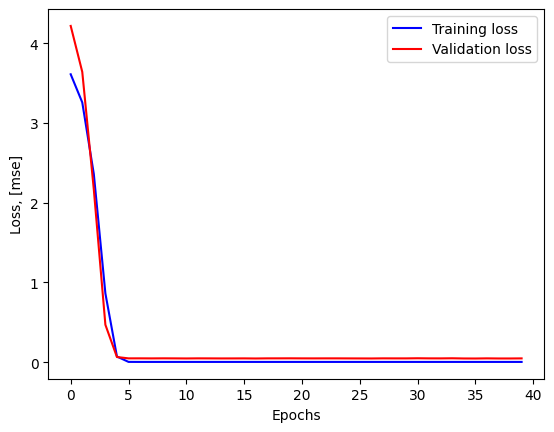

In [7]:
plt.plot(history.history['loss'],
         'b',
         label='Training loss')
plt.plot(history.history['val_loss'],
         'r',
         label='Validation loss')
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Loss, [mse]')
plt.show()

In [8]:
model.save('../models/lstm_autoencoder.h5')